In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

# データの確認・可視化

In [2]:
#データのインポート
data = pd.read_csv('./train.csv', index_col='datetime', parse_dates=True)
data.index = pd.DatetimeIndex(data.index.values, freq=data.index.inferred_freq)
data.head()

,y,client,close,price_am,price_pm
2010-07-01,17,0,0,-1,-1
2010-07-02,18,0,0,-1,-1
2010-07-03,20,0,0,-1,-1
2010-07-04,20,0,0,-1,-1
2010-07-05,14,0,0,-1,-1


In [3]:
data.shape

(2101, 5)

In [4]:
data['y'] = data['y'].astype('int32')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2101 entries, 2010-07-01 to 2016-03-31
Freq: D
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   y         2101 non-null   int32
 1   client    2101 non-null   int64
 2   close     2101 non-null   int64
 3   price_am  2101 non-null   int64
 4   price_pm  2101 non-null   int64
dtypes: int32(1), int64(4)
memory usage: 90.3 KB


欠測値なし、datetime列がobject型になっているのを確認

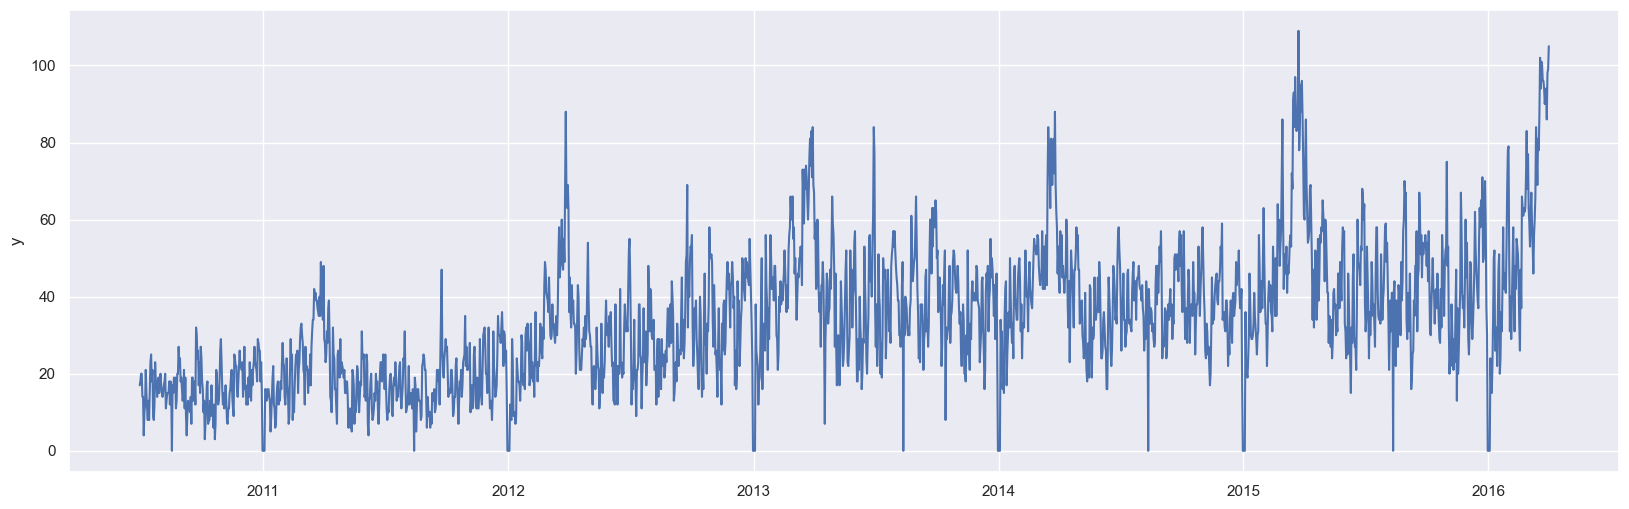

In [6]:
#各特徴量毎に時系列順にプロットしてみる
plt.figure(figsize=(20,6))
plt.plot(data['y'])
plt.ylabel('y')
plt.show()

yには長期的なトレンド、季節性があることが見て取れる

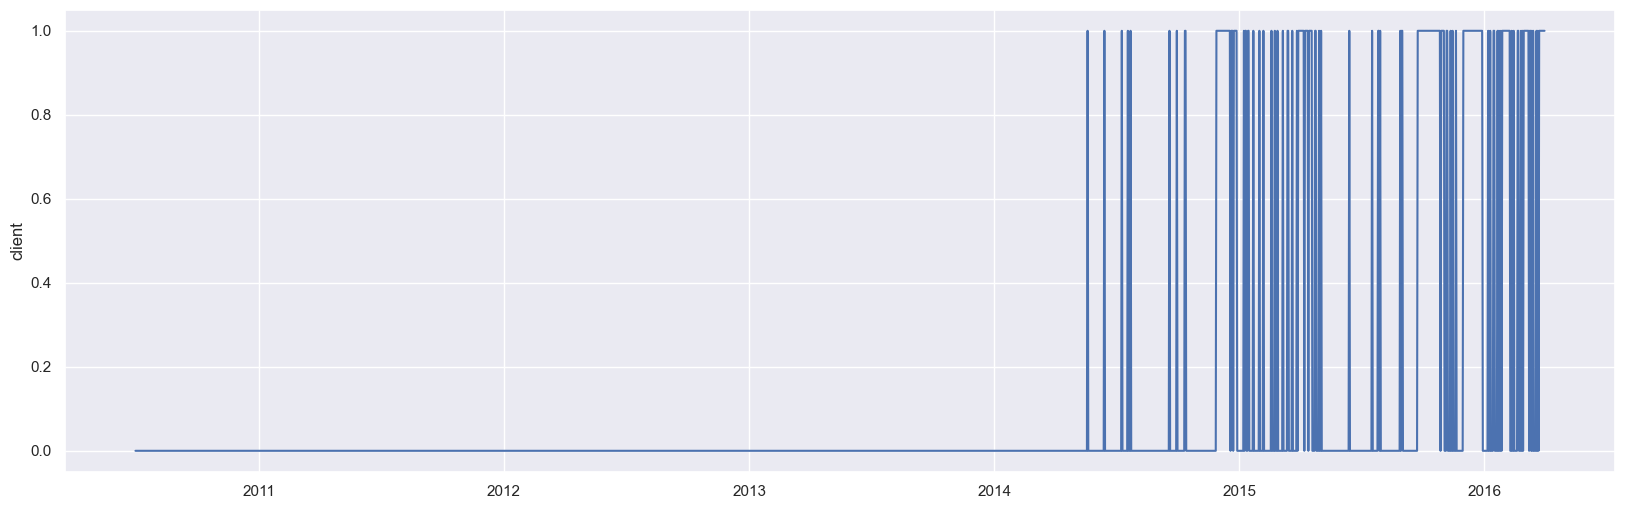

In [7]:
plt.figure(figsize=(20,6))
plt.plot(data['client'])
plt.ylabel('client')
plt.show()

client(法人利用日)は2014年半ば頃から発生している

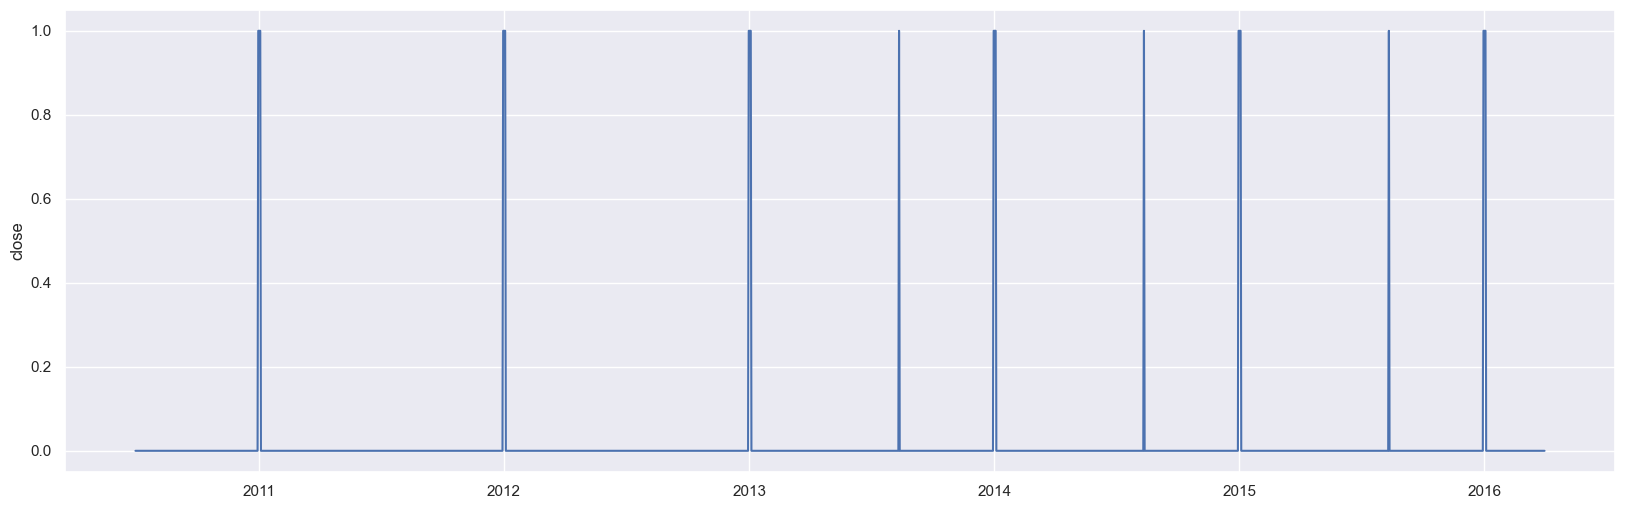

In [8]:
plt.figure(figsize=(20,6))
plt.plot(data['close'])
plt.ylabel('close')
plt.show()

close（休業日）は、年末年始に数日間ある。また2013年から夏季休暇を導入したことが見て取れる

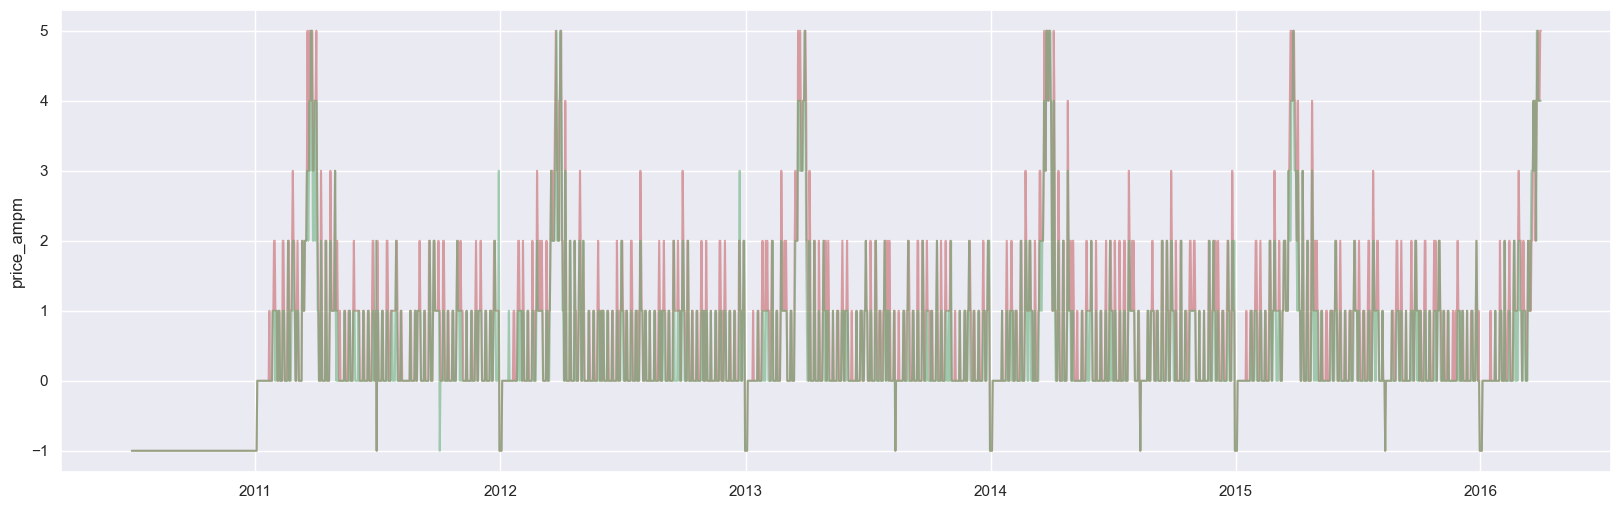

In [9]:
plt.figure(figsize=(20,6))
plt.plot(data['price_am'], c='r', alpha=0.5)
plt.plot(data['price_pm'], c='g', alpha=0.5)
plt.ylabel('price_ampm')
plt.show()

料金区分には一定の周期性が見て取れる。おそらく、繁忙期（3月4月）は料金を高く設定しているのだろう\
またam,pmがおおむね重なっていることから、一日の料金区分はそこまで変動しないと思われる。\
price_am、price_pmで特徴量を分ける必要はない？？

## 欠損値の解釈

price_am, price_pmには2010年において、データがすべて-1となっていることが確認できた。\
price_am, price_pmとcloseの関係を見てみると、休業日にprice_am,pmが-1になっていると思われる。\
以上のことから、2010年のprice_am,pmの値は欠損データだと判断する。\
欠測メカニズムとしては、MARが妥当。\

## 自己相関係数と偏自己相関係数を可視化する

C:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


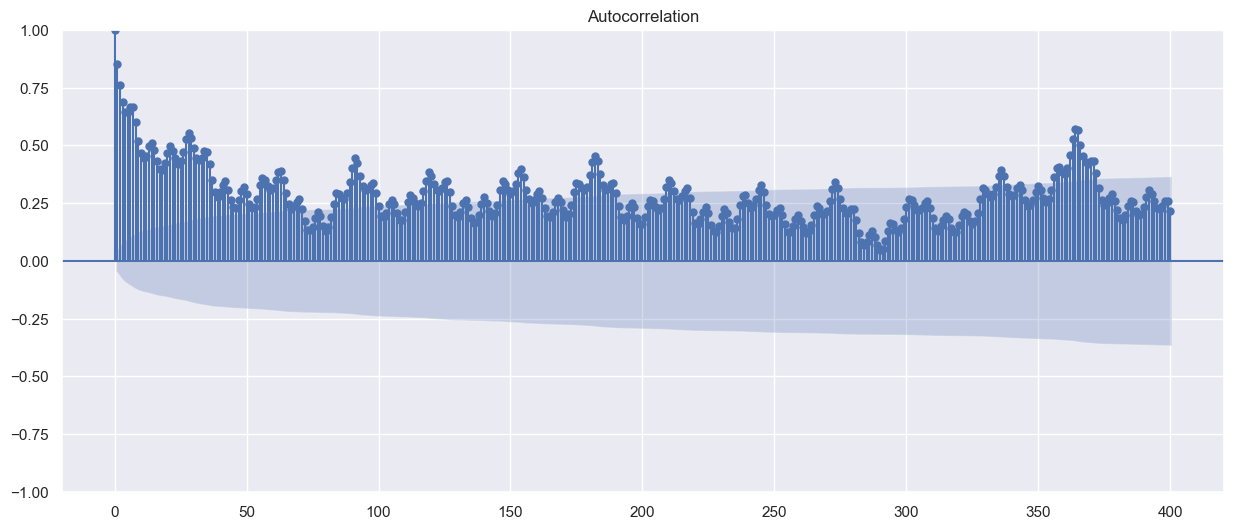

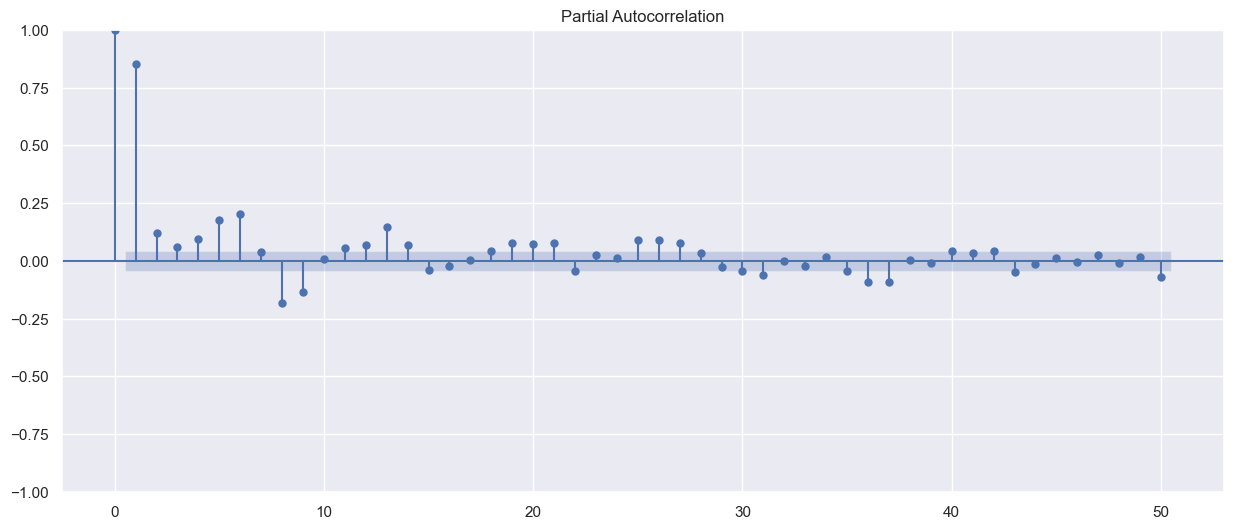

In [10]:
fig_1 = sm.graphics.tsa.plot_acf(data['y'], lags=400)
fig_2 = sm.graphics.tsa.plot_pacf(data['y'], lags=50)

## 波状分解してみる

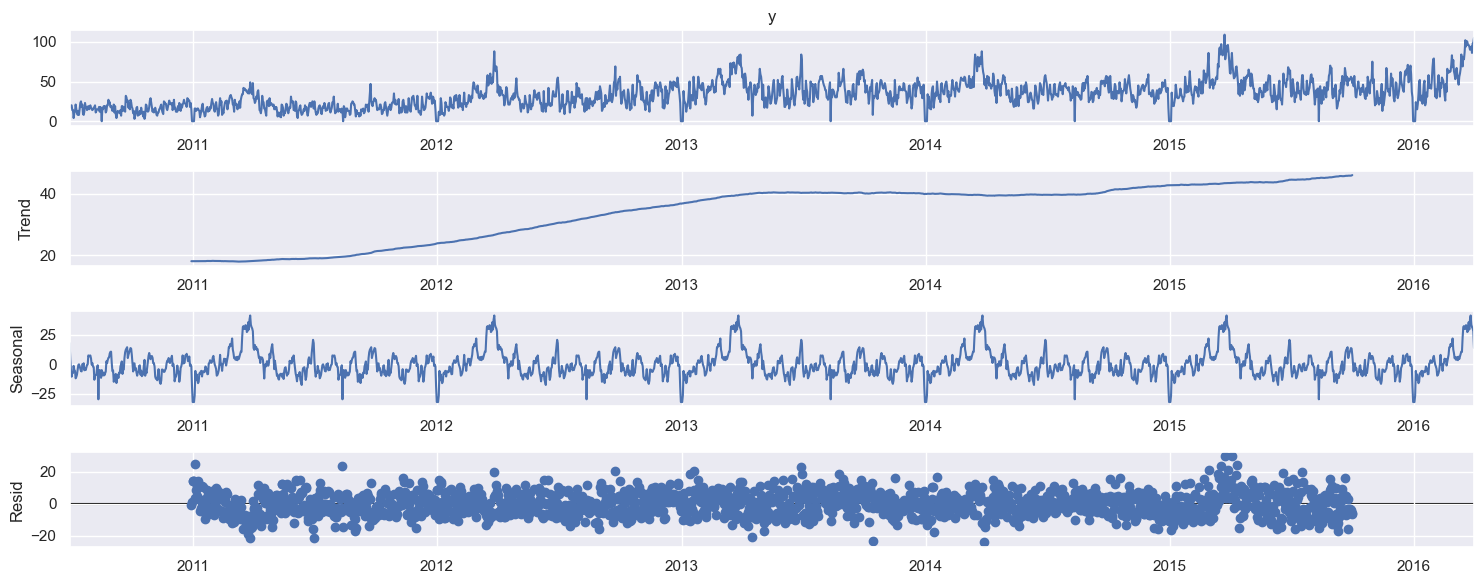

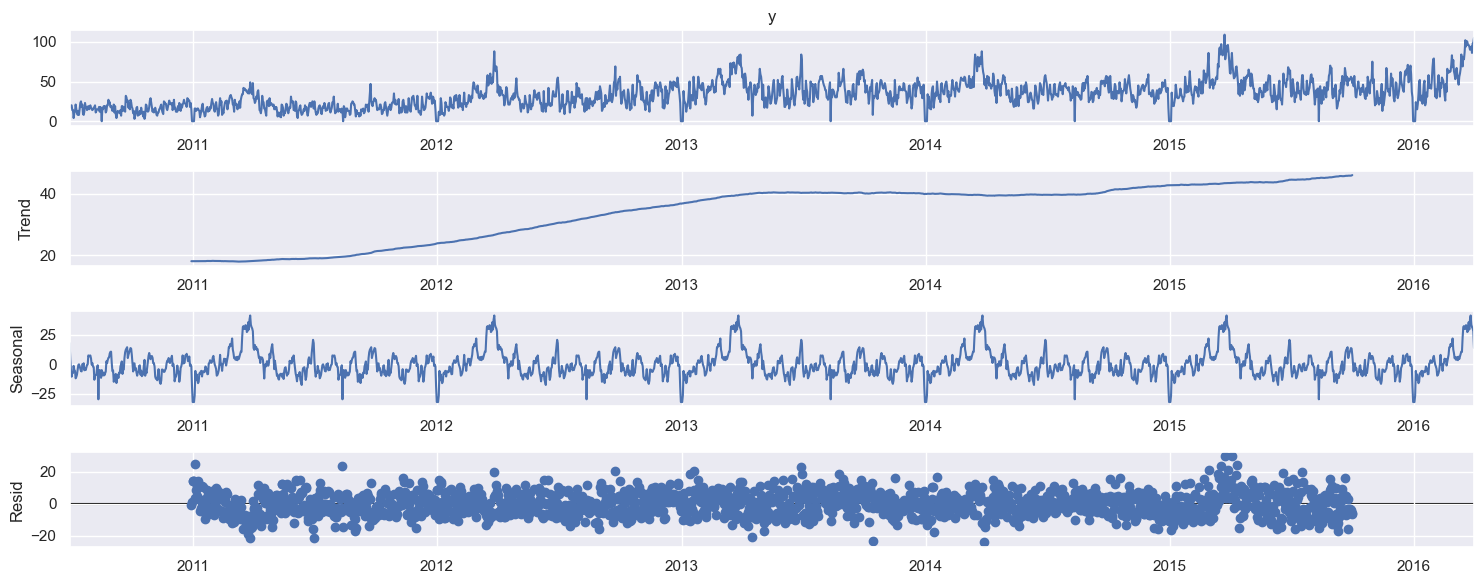

In [11]:
result = seasonal_decompose(data['y'], period=365, two_sided=True)
result.plot()

# 単位根検定する

In [12]:
print('-----------原系列-----------')
nc = sm.tsa.stattools.adfuller(data['y'], regression='nc')
c = sm.tsa.stattools.adfuller(data['y'], regression='c')
ct = sm.tsa.stattools.adfuller(data['y'], regression='ct')
ctt = sm.tsa.stattools.adfuller(data['y'], regression='ctt')

print('nc p-value:' + str(nc[1]))
print('c p-value:' + str(c[1]))
print('ct p-value:' + str(ct[1]))
print('ctt p-value:' + str(ctt[1]))

print()
print('--------一次階差系列---------')
data_diff = data['y'].diff().dropna()

nc = sm.tsa.stattools.adfuller(data_diff, regression='nc')
c = sm.tsa.stattools.adfuller(data_diff, regression='c')
ct = sm.tsa.stattools.adfuller(data_diff, regression='ct')
ctt = sm.tsa.stattools.adfuller(data_diff, regression='ctt')

print('nc p-value:' + str(nc[1]))
print('c p-value:' + str(c[1]))
print('ct p-value:' + str(ct[1]))
print('ctt p-value:' + str(ctt[1]))

-----------原系列-----------
nc p-value:0.8083881646861255
c p-value:0.574756432591289
ct p-value:0.09709464701227466
ctt p-value:0.33861041529458824

--------一次階差系列---------


C:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(
C:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:821: FutureWarning: trend 'nc' has been renamed to 'n' after 0.14 is released. Use 'n' now to avoid this warning.
  warnings.warn(


nc p-value:1.2818140183684502e-27
c p-value:8.112058795132015e-29
ct p-value:1.1439839640925883e-22
ctt p-value:1.436231272563402e-24


原系列では、単位根検定のｐ値がすべて5%を超えている。\
対して階差をとった系列では、ｐ値は十分小さくなっているため、一次階差系列は定常データだといえそう。

# ベースラインモデルを作成する

In [13]:
#まずはARMAモデルにて最適な次数を探索
params2 = sm.tsa.arma_order_select_ic(data_diff, ic='aic')
params2

C:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


{'aic':               0             1             2
 0  15355.426380  15251.602436  15162.528337
 1  15280.828980  15081.180356  15082.449415
 2  15255.204691  15082.369810  15083.643095
 3  15216.969370  15082.204865  15084.193469
 4  15120.838108  15054.979846  15085.314765,
 'aic_min_order': (4, 1)}

以上より、ARIMA(4,1,1)が適切だと判断

In [14]:
#SARIMAでの最適な次数を探索
import itertools
p = range(0,2)
d = range(0,2)
q = range(0,2)
pdg = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0], x[1], x[2], 365) for x in list(itertools.product(p,d,q))]

In [ ]:
best_param_seasonal = [0,0,0,0]
best_aic = 999999

best_param = (1,1,1)

for param_seasonal in seasonal_pdq:
    try:
        mod = sm.tsa.statespace.SARIMAX(data['y'], order=best_param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
        results = mod.fit()
        print('ARIMA{}x{}365 - AIC:{}'.format(best_param, param_seasonal, results.aic))

        if best_aic > results.aic:
            best_param_seasonal = param_seasonal
            best_aic = results.aic
    
    except:
        continue

print('*BEST ARIMA{}x{}365 - AIC:{}'.format(best_param, best_param_seasonal, best_aic))


ARIMA(1, 1, 1)x(0, 0, 0, 365)365 - AIC:15068.265527375665


In [14]:
#訓練データと検証データに分割
train_data = data[:"2015-03-31"]
test_data = data["2015-04-01":]

In [23]:
sarima_model = sm.tsa.SARIMAX(train_data['y'], order=(1,1,1), seasonal_order=(1,1,1,360))
result = sarima_model.fit()

result.summary()

C:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ayumi\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


MemoryError: Unable to allocate 6.76 GiB for an array with shape (723, 723, 1735) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1004, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions._ArrayMemoryError: Unable to allocate 6.76 GiB for an array with shape (723, 723, 1735) and data type float64


AttributeError: Memoryview is not initialized

In [16]:
best_pred = result.predict(start='2015-04-01', end='2016-03-31')

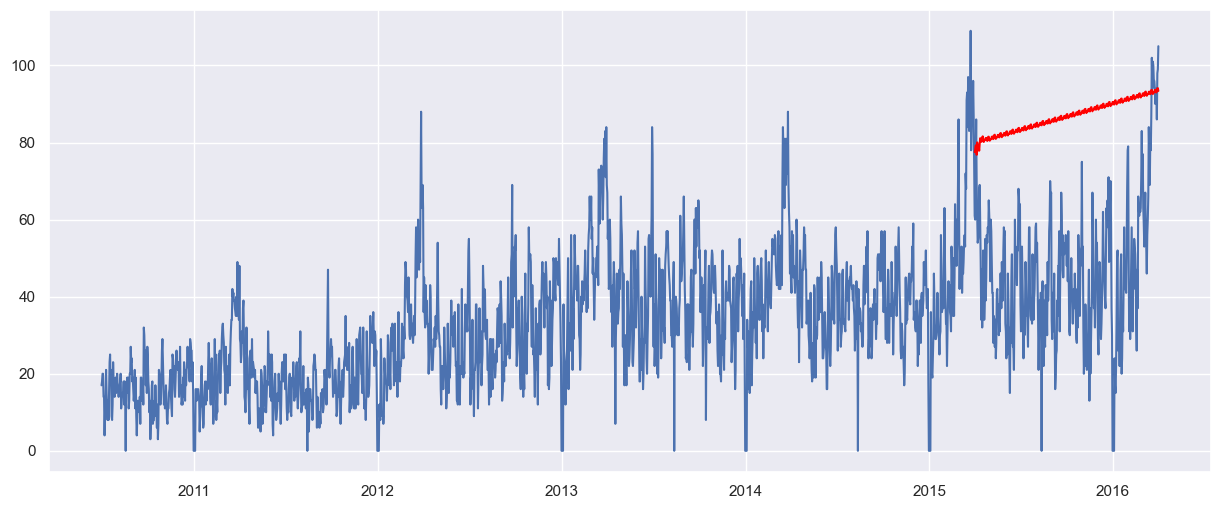

In [20]:
plt.plot(data['y'])
plt.plot(best_pred, c='red')
plt.show()